In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

/home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your time series data
# df = pd.read_csv('your_timeseries.csv')  # expects columns: 'ds' (date), 'y' (value)
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df.columns = ['ds', 'y']  # Prophet requires these column names
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds')


In [3]:
# Split train/test (last 12 months as test)
train = df.iloc[:-12].copy()
test = df.iloc[-12:].copy()


In [6]:
####################
# Prophet Forecast
####################
prophet = Prophet()
prophet.fit(train)
future = prophet.make_future_dataframe(periods=12, freq='MS')
forecast = prophet.predict(future)
y_pred_prophet = forecast.set_index('ds').loc[test['ds'], 'yhat']

12:04:15 - cmdstanpy - INFO - Chain [1] start processing
12:04:15 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
####################
# SARIMA Forecast
####################
sarima_model = auto_arima(train['y'], seasonal=True, m=12)
y_pred_sarima = sarima_model.predict(n_periods=12)

/home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/deadshot/GitHub/timeseries-forecasting-hub

In [9]:
####################
# ETS Forecast
####################
ets_model = ExponentialSmoothing(train['y'], trend='add', seasonal='add', seasonal_periods=12).fit()
y_pred_ets = ets_model.forecast(12)

In [11]:
####################
# XGBoost Forecast
####################
# Feature Engineering
full_df = df.copy()
full_df['month'] = full_df['ds'].dt.month
full_df['year'] = full_df['ds'].dt.year
full_df['lag_1'] = full_df['y'].shift(1)
full_df['lag_12'] = full_df['y'].shift(12)

full_df = full_df.dropna()
X = full_df[['month', 'year', 'lag_1', 'lag_12']]
y = full_df['y']

# Train/test split for XGBoost
X_train = X.iloc[:-12]
y_train = y.iloc[:-12]
X_test = X.iloc[-12:]

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


XGBoostError: [12:05:24] /workspace/src/data/array_interface.cu:44: Check failed: err == cudaGetLastError() (0 vs. 46) : 
Stack trace:
  [bt] (0) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7008300a6acc]
  [bt] (1) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xb84c1c) [0x700830984c1c]
  [bt] (2) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x5649ce) [0x7008303649ce]
  [bt] (3) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0x10b) [0x70082ffb3a5b]
  [bt] (4) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/lib-dynload/../../libffi.so.8(+0xa052) [0x7008c1f4e052]
  [bt] (5) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/lib-dynload/../../libffi.so.8(+0x8925) [0x7008c1f4c925]
  [bt] (6) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x7008c1f4d06e]
  [bt] (7) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x9c88) [0x7008c1f5ec88]
  [bt] (8) /home/deadshot/GitHub/timeseries-forecasting-hub/venv/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8c44) [0x7008c1f5dc44]



In [12]:
####################
# Evaluation
####################
y_true = test['y'].values
print("\nModel Performance (MAPE):")
print("Prophet:", mean_absolute_percentage_error(y_true, y_pred_prophet))
print("SARIMA :", mean_absolute_percentage_error(y_true, y_pred_sarima))
print("ETS    :", mean_absolute_percentage_error(y_true, y_pred_ets))
# print("XGBoost:", mean_absolute_percentage_error(y_true, y_pred_xgb))


Model Performance (MAPE):
Prophet: 0.06614227312976799
SARIMA : 0.03097561537702942
ETS    : 0.02802823947659527


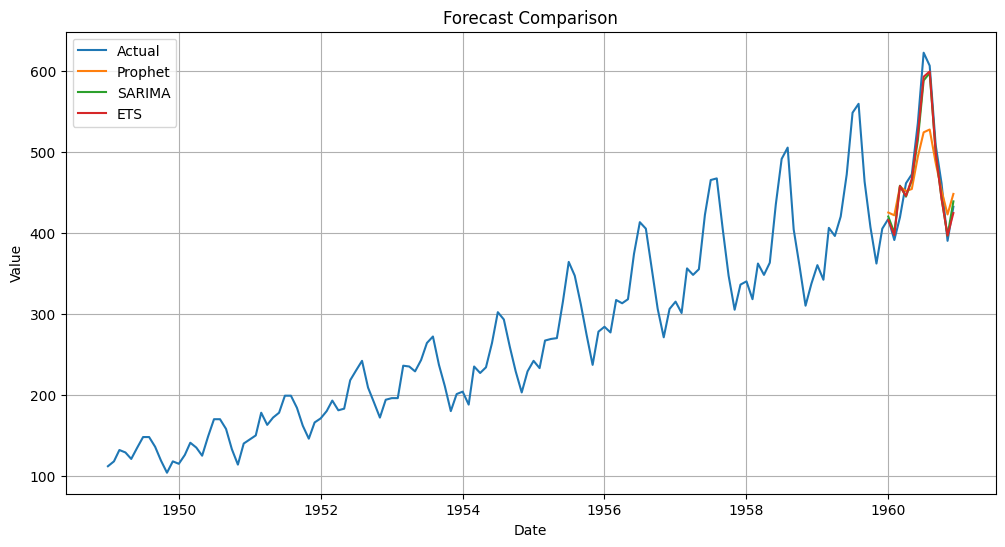

In [13]:
####################
# Plot Forecasts
####################
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(test['ds'], y_pred_prophet, label='Prophet')
plt.plot(test['ds'], y_pred_sarima, label='SARIMA')
plt.plot(test['ds'], y_pred_ets, label='ETS')
# plt.plot(test['ds'], y_pred_xgb, label='XGBoost')
plt.legend()
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()
